# 1. Logistic regression with Python
## 1.1 Preparation of imaginary data

In [1]:
!pip install ISLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 89.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=936a93dad5775aa5f6cc5fa3248ad7bb57f520f097efd390c2292c2a05cb0508
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
from torch import nn

In [9]:
import pandas as pd
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
pima = pd.read_csv("diabetes.csv", header=0, names=col_names)

In [10]:
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # Features
y = pima.label # Target variable

In [12]:
X.shape

(768, 7)

In [13]:
n=X.shape[0]
X = torch.tensor(X.values, dtype=torch.float32)
Y = torch.tensor(y.values, dtype=torch.float32).reshape([n,1])

In [14]:
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)

In [15]:
XX = (X-X_mean)/X_std
dataset = TensorDataset(XX,Y)
trainloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

## 1.2 Logistic regression

Assume

$y_i \sim {\rm Ber}(p_i)\quad$   for $\quad i=1, \cdots, n$

where $p_i=\sigma(X_iW+b)$. Here, $\sigma$ is a sigmoid function defined by

$\sigma(x)=\frac{1}{1+\exp(-x)}$.

In torch, we use `torch.sigmoid(x)`.

Then likelihood function is given by

$L(W, b):=\prod\limits_{i=1}^{n}f_{W, b}(y_i; X_i)$

where

$f_{W, b}(y_i; X_i)=\left(p_i\right)^{y_i}\left(1-p_i\right)^{1-y_i}=
\begin{cases}
p_i, & y_i=1;\\
1-p_i, & y_i=0.\\
\end{cases}
$

In [12]:
linear_model = torch.nn.Linear(7,1, bias=True)
def neg_log_lik(phat,y):
    out = -1 * torch.mean(y * torch.log(phat) + (1 - y) * torch.log(1 - phat))
    return out
my_optimizer = torch.optim.SGD(linear_model.parameters(), lr = 0.1)

In [13]:
epochs=100
history=[]
n=XX.shape[0]


for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    p_lin = linear_model(xx)
    phat = torch.sigmoid(p_lin)
    loss = neg_log_lik(phat, yy)
    LOSS_sum = LOSS_sum + loss * len(yy)
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
  history.append(LOSS_sum.item()/n)


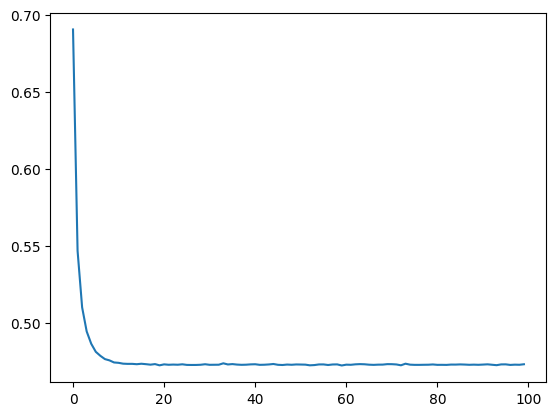

In [14]:
import matplotlib.pyplot as plt
plt.plot(history)

### 1.2.1 Classification

Now we calculate accuracy of the classification.

Let's start with the classification.

We classify

$
\widehat{y}_i
=\begin{cases}
1, & \widehat{p}_i >0.5;\\
0, & \widehat{p}_i \le 0.5.
\end{cases}
$

Calculate the probability of diabete of the first person:

```
['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree'] = [  6.0000,   0.0000,  33.6000,  50.0000, 148.0000,  72.0000,   0.6270]
```

In [15]:
xx = (torch.tensor([[  6.0000,   0.0000,  33.6000,  50.0000, 148.0000,  72.0000,   0.6270]])-X_mean)/X_std
phat = torch.sigmoid(linear_model(xx))
phat


tensor([[0.7212]], grad_fn=<SigmoidBackward0>)

Then, accuracy is calculated as follows:

In [16]:
phat = torch.sigmoid(linear_model(XX))
yhat = (phat>0.5).type(torch.float32)

accuracy = torch.mean((Y == yhat).type(torch.float32))
accuracy

tensor(0.7852)

In [ ]:
phat[0:3]

tensor([[0.7197],
        [0.0479],
        [0.7966]], grad_fn=<SliceBackward0>)

### 1.2.2 Custom Layer

Here, we use custom layer to define the logistic model:

In [ ]:
class my_logistic(torch.nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.linear = torch.nn.Linear(in_units, units, bias=True)

    def forward(self, X):
        temp = torch.sigmoid(self.linear(X))
        return temp

Note that we have `sigmoid` function inside the layer. Now, we train the model

In [ ]:
linear_model = my_logistic(7,1)
def neg_log_lik(phat,y):
    out = -1 * torch.mean(y * torch.log(phat) + (1 - y) * torch.log(1 - phat))
    return out
my_optimizer = torch.optim.SGD(linear_model.parameters(), lr = 0.1)

In [ ]:
epochs=100
history=[]
n=XX.shape[0]


for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader:
    phat = linear_model(xx)
    loss = neg_log_lik(phat, yy)
    LOSS_sum = LOSS_sum + loss * len(yy)
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
  history.append(LOSS_sum.item()/n)

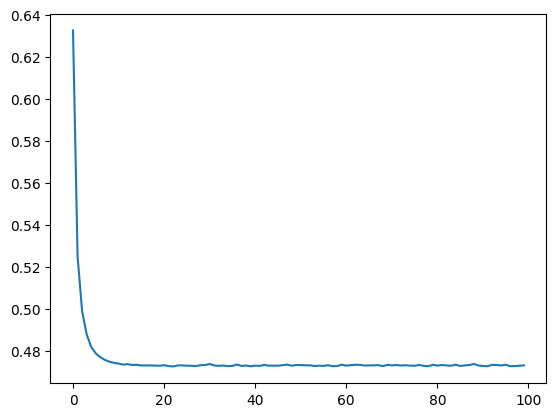

In [ ]:
plt.plot(history)

Caculate the accyracy:

In [ ]:
phat = linear_model(XX)
yhat = (phat>0.5)*1.0

In [ ]:
accuracy = torch.mean((Y == yhat)*1.0)
accuracy

tensor(0.7852)

### 1.2.3 Sequential model

`torch.nn.Sequential` 은 순서를 갖는 모듈의 컨테이너입니다. 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달됩니다. 순차 컨테이너(sequential container)를 사용하여 아래의 seq_modules 와 같은 신경망을 빠르게 만들 수 있습니다.

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(7,1, bias=True),
    torch.nn.Sigmoid()
)
yhat = model(XX)

The above code can be understood as follows:

```
mod1 = torch.nn.Linear(7,1, bias=True)
mod2 = torch.nn.Sigmoid()
yhat = mod2(mod1(X))
```

### Exercise 1.2.3.1

Complete the training using the above code, and calculate the train accuracy.

In [ ]:


def criterion(yhat0,y0):
    out = -1 * torch.mean(y0 * torch.log(yhat0) + (1 - y0) * torch.log(1 - yhat0))
    return out

# Build in criterion
# criterion = nn.BCELoss()
learning_rate = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

#### Exercise 1.2.3.2

So far we have used the following loss function:

```
def neg_log_lik(phat,y):
    out = -1 * torch.mean(y * torch.log(phat) + (1 - y) * torch.log(1 - phat))
    return out
```

Equivalently, you can use `torch.distributions.bernoulli.Bernoulli` function to define the loss function. Train the model again using this loss function, and calculate the train accuracy.


In [ ]:
history=[]
epochs=10000
for epoch in range(epochs):
        Phat = model(X)
        LOSS = criterion(Phat, Y)
        #LOSS = torch.nn.functional.binary_cross_entropy(Phat, Y)
        history.append(LOSS.item())
        optimizer.zero_grad()
        LOSS.backward()
        optimizer.step()


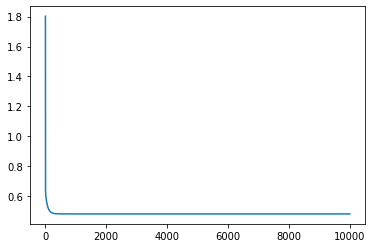

In [ ]:
plt.plot(history)

In [ ]:
yhat = model(X)
yhat

tensor([[0.2131],
        [0.5651],
        [0.3318],
        [0.8471],
        [0.9196],
        [0.9104],
        [0.2131]], grad_fn=<SigmoidBackward0>)

In [ ]:

yhat = model(X)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == Y).type(torch.float)))

The accuracy:  tensor(0.7143)


## Exercise 1.2.3: Heart attack patients


Suppose that we are working with some doctors on heart attack patients. The dependent variable is whether the patient has had a second heart attack ($Y$)within 1 year (yes = 1). We have two independent variables, one is whether the patient completed a treatment consistent of anger control practices ($W_1$) (yes=1). The other is a score on a trait anxiety scale ($W_2$) (a higher score means more anxious). You want to model

$Y\sim {\rm Ber}(p_i)$

where $p_i=\sigma(x_iW+b)$ with $W=
\left(\begin{matrix}
W_1\\
W_2
\end{matrix}\right).
$

Answer the following problems:

1. Build the model which best describe the heart attack mechanism. You may want to standardize the explanatory variables before define the model.

2. Using the model, train the model.

3. What is the probability that a person of

`Treatment of Anger =1` and `Trait Anxiety =75`

4. Calculate the train accuracy of the model.

<img src="https://drive.google.com/uc?id=1BJMmWmeDUJFXis6nc7X7Sd6o832B1_OC" height="600" width="400">

In [ ]:
data = np.array([[1,1,70], [1,1,80], [1,1,50],[1,0,60], [1,0,40], [1, 0, 65], [1,0,75], [1,0,80], [1,0,70], [1,0,60], [0,1,65], [0,1,50], [0,1,45], [0,1,35], [0,1,40], [0,1,50], [0,0,55], [0,0,45], [0,0,50], [0,0,60]], dtype=np.float32)
data

array([[ 1.,  1., 70.],
       [ 1.,  1., 80.],
       [ 1.,  1., 50.],
       [ 1.,  0., 60.],
       [ 1.,  0., 40.],
       [ 1.,  0., 65.],
       [ 1.,  0., 75.],
       [ 1.,  0., 80.],
       [ 1.,  0., 70.],
       [ 1.,  0., 60.],
       [ 0.,  1., 65.],
       [ 0.,  1., 50.],
       [ 0.,  1., 45.],
       [ 0.,  1., 35.],
       [ 0.,  1., 40.],
       [ 0.,  1., 50.],
       [ 0.,  0., 55.],
       [ 0.,  0., 45.],
       [ 0.,  0., 50.],
       [ 0.,  0., 60.]], dtype=float32)

## Exercise 2. Repeat the above using custom layer.